# 多头注意力机制

- 希望给定相同的 `query`, `key` 和 `value`, 可以计算得到不同的值；
- 那么使用不同的矩阵去乘 `query`, `key` 和 `value`, 相当于是得到了不同的 `qkv`;
- 然后使用不同的 `qkv` 去计算 `attention` 的值, 最后将不同的值合并起来

In [1]:
import torch
from torch import nn
from lib.d2l_torch import Module, DotProductAttention, show_heatmaps

## 逐步进行分析

In [2]:
batch_size = 2 # batch 数量
num_heads = 5 # multi head 的数量
num_queries = 4 # query 的数量为 4
num_kvpairs =  6 # kvpair 的数量为 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, 10)) # query
Y = torch.ones((batch_size, num_kvpairs, 20)) # key, value
print(X.shape, Y.shape)

torch.Size([2, 4, 10]) torch.Size([2, 6, 20])


In [33]:
def _transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状, 不要因为 multi-head, 而多一个循环
    """
    # 输入 X 的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出 X 的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    # 有多少个 head, 做一下切分, 比如会从 torch.Size([2, 4, 100]) --> torch.Size([2, 4, 5, 20])
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    # 交换维度, 将 num_heads 和 查询或者“键－值”对的个数 交换
    # 此时的大小为 torch.Size([2, 5, 4, 20])
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    # 最终大小变为 torch.Size([10, 4, 20])
    return X.reshape(-1, X.shape[2], X.shape[3])

利用 `W` 计算得到多组 `qkv`.

In [36]:
num_hiddens = 100
W_q = nn.LazyLinear(num_hiddens, bias=False)
W_k = nn.LazyLinear(num_hiddens, bias=False)
W_v = nn.LazyLinear(num_hiddens, bias=False)

queries = _transpose_qkv(X=W_q(X), num_heads=num_heads) # torch.Size([10, 4, 20])
keys = _transpose_qkv(W_k(Y), num_heads=num_heads) # torch.Size([10, 6, 20])
values = _transpose_qkv(W_v(Y), num_heads=num_heads) # torch.Size([10, 6, 20])
print(queries.shape, keys.shape, values.shape)

torch.Size([10, 4, 20]) torch.Size([10, 6, 20]) torch.Size([10, 6, 20])


In [38]:
attention = DotProductAttention(0.1)

valid_lens = torch.repeat_interleave(valid_lens, repeats=num_heads, dim=0)
output = attention(queries, keys, values, valid_lens)
print(output.shape) # 计算每个 query 的值, 为 (10, 4, 20)

torch.Size([10, 4, 20])


我们相当于是将 multihead 的当作不同 batch 在计算, 现在需要把 mutil-head 放回去.

In [40]:
def _transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作
    """
    # 将 num_heads 的维度信息从 batch size 中拿出来
    # 也就是 torch.Size([10, 4, 20]) --> torch.Size([2, 5, 4, 20]), 这里 num_head = 5
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    # 交换 num_heads 与 查询或者“键－值”对的个数
    # 此时从 torch.Size([2, 5, 4, 20]) --> torch.Size([2, 4, 5, 20])
    X = X.permute(0, 2, 1, 3)
    # 最后将 num_head 的信息合并起来
    # 从 torch.Size([2, 4, 5, 20]) --> torch.Size([2, 4, 100])
    return X.reshape(X.shape[0], X.shape[1], -1)

In [41]:
output_concat = _transpose_output(output, num_heads=num_heads)
print(output_concat.shape) # 将 num_head 从 batch_size 中拿出来, torch.Size([10, 4, 20]) --> torch.Size([2, 4, 100])
# 这里的 100 相当于是 multi-head 集和后的结果

torch.Size([2, 4, 100])


In [44]:
W_o = nn.LazyLinear(32, bias=False)
result = W_o(output_concat)
print(result.shape) # torch.Size([2, 4, 100]) --> torch.Size([2, 4, 32])

torch.Size([2, 4, 32])


## 写成一层

定义 `Multihead Attention`, 相当于是一层网络.

In [12]:
class MultiHeadAttention(Module):
    """Multi-head attention. (这个可以作为 Layer)
    """
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads # head 的数量
        self.attention_weight = None # 记录 attention weight, 后面进行可视化
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)


    def _transpose_qkv(self, X, num_heads):
        """为了多注意力头的并行计算而变换形状, 不要因为 multi-head, 而多一个循环
        """
        # 输入 X 的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
        # 输出 X 的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
        # 有多少个 head, 做一下切分, 比如会从 torch.Size([2, 4, 100]) --> torch.Size([2, 4, 5, 20])
        X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

        # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
        # 交换维度, 将 num_heads 和 查询或者“键－值”对的个数 交换
        # 此时的大小为 torch.Size([2, 5, 4, 20])
        X = X.permute(0, 2, 1, 3)

        # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
        # 最终大小变为 torch.Size([10, 4, 20])
        return X.reshape(-1, X.shape[2], X.shape[3])


    def _transpose_output(self, X, num_heads):
        """逆转transpose_qkv函数的操作
        """
        # 将 num_heads 的维度信息从 batch size 中拿出来
        # 也就是 torch.Size([10, 4, 20]) --> torch.Size([2, 5, 4, 20]), 这里 num_head = 5
        X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
        # 交换 num_heads 与 查询或者“键－值”对的个数
        # 此时从 torch.Size([2, 5, 4, 20]) --> torch.Size([2, 4, 5, 20])
        X = X.permute(0, 2, 1, 3)
        # 最后将 num_head 的信息合并起来
        # 从 torch.Size([2, 4, 5, 20]) --> torch.Size([2, 4, 100])
        return X.reshape(X.shape[0], X.shape[1], -1)


    def forward(self, queries, keys, values, valid_lens, window_mask=None):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)

        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        queries = self._transpose_qkv(X=self.W_q(queries), num_heads=self.num_heads) # torch.Size([10, 4, 20])
        keys = self._transpose_qkv(self.W_k(keys), num_heads=self.num_heads) # torch.Size([10, 6, 20])
        values = self._transpose_qkv(self.W_v(values), num_heads=self.num_heads) # torch.Size([10, 6, 20])

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries, num_hiddens / num_heads)
        # multi-head 合成一个 head, 作一次 attention, 再转换回来
        output = self.attention(queries, keys, values, valid_lens, window_mask)
        self.attention_weight = self.attention.attention_weights # 记录 attention weight
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self._transpose_output(output, num_heads=self.num_heads)
        return self.W_o(output_concat)

使用测试数据进行测试

In [14]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
attention.eval()

batch_size = 2
num_queries = 4 # query 的数量为 4
num_kvpairs =  6 # kvpair 的数量为 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens)) # query
Y = torch.ones((batch_size, num_kvpairs, num_hiddens)) # key, value
print(attention(X, Y, Y, valid_lens).shape)

torch.Size([2, 4, 100])


可视化 attention weight

In [15]:
# (batch_size * num_head, no. of queries, num_hiddens)
print(attention.attention_weight.shape)

torch.Size([10, 4, 6])


In [17]:
attention_weights = attention.attention_weight
attention_weights = attention_weights.reshape(2, 5, attention_weights.shape[1], attention_weights.shape[2])
print(attention_weights[-1].shape)

torch.Size([5, 4, 6])


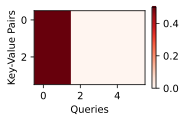

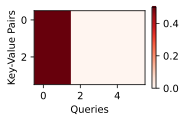

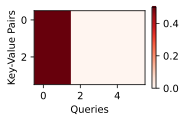

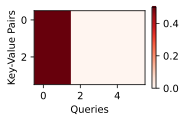

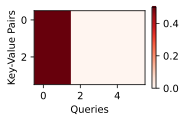

In [21]:
for i in range(5):
    show_heatmaps(
        matrices=[[attention_weights[-1][i]]],
        xlabel='Queries',
        ylabel='Key-Value Pairs'
    )